姓名：何子安

學號：E44065020

課程：資料分析與學習基石

作業：1

# import libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msn
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# reading data into dataframe

In [2]:
df = pd.read_csv('data.csv')
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


# EDA

Sentence     0
Sentiment    0
dtype: int64


<AxesSubplot:>

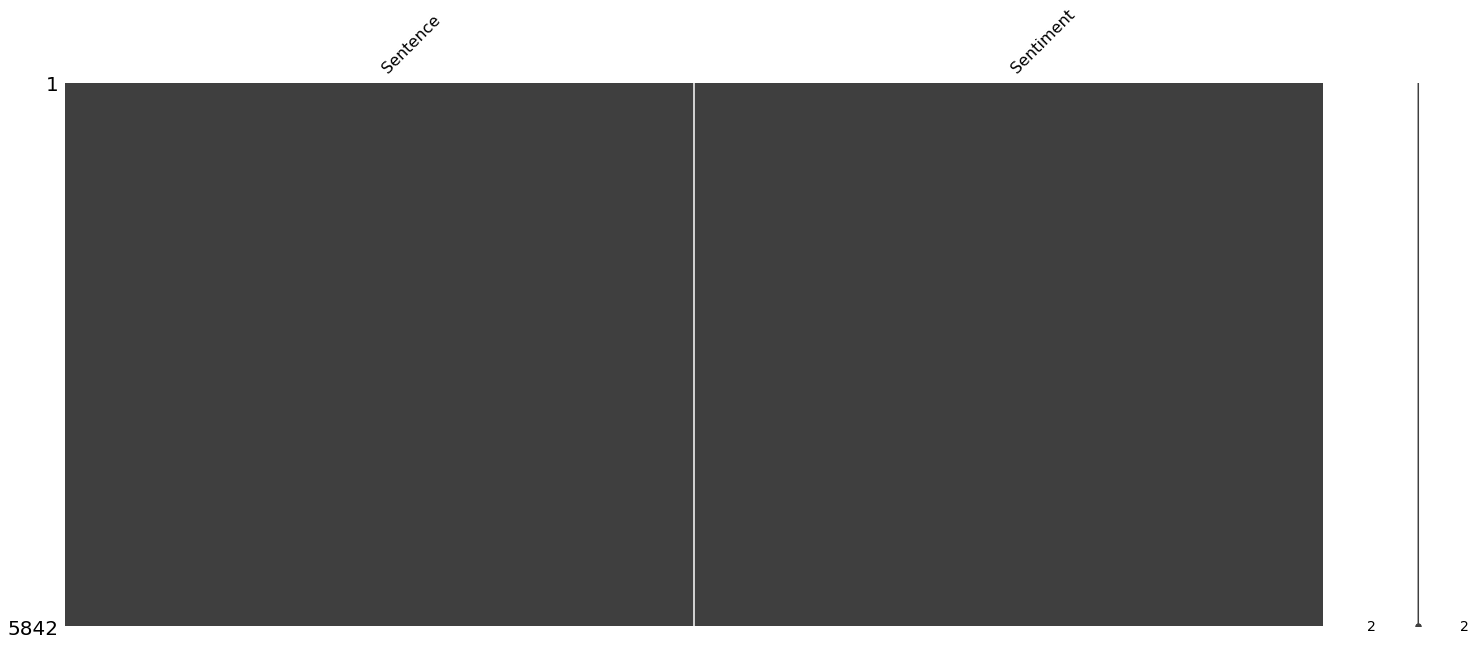

In [3]:
print(df.isnull().sum())
msn.matrix(df)

there are no missing value in the data and we have 5842 rows of data.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [5]:
df['Sentiment'].value_counts()

neutral     3130
positive    1852
negative     860
Name: Sentiment, dtype: int64

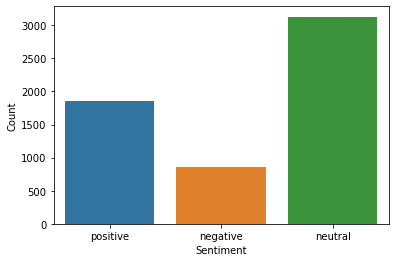

In [6]:
sns.countplot(x='Sentiment', data=df)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [7]:
neutral, pos, neg = df['Sentiment'].value_counts()
total = neutral + pos + neg
for i, j in zip(['neutral', 'positive', 'negative'], df['Sentiment'].value_counts()):
    print(f'{i}: {round(j/total*100, 2)}%')

neutral: 53.58%
positive: 31.7%
negative: 14.72%


neutral的句子佔了一半以上（53.58%），positive的句子佔了31.7%，而negative的句子則佔了最少數量（14.72%）。

這也說明了該資料集是imbalance的。

## apply labels encoding into `Sentiment` column

In [8]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])
df['Sentiment'].unique()

df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,2
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",0
2,"For the last quarter of 2010 , Componenta 's n...",2
3,According to the Finnish-Russian Chamber of Co...,1
4,The Swedish buyout firm has sold its remaining...,1


## wordcloud of sentence text

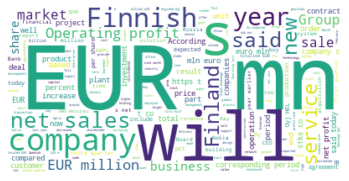

In [9]:
stopwords_ = set(STOPWORDS)

text = " ".join(i for i in df.Sentence)
wordcloud = WordCloud(stopwords=stopwords_, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# cleaning the sentence

In [10]:
nltk.download('stopwords')

corpus = []
for i in range(0, len(df)):
    review = re.sub('[^a-zA-Z]', ' ', df['Sentence'][i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    review = [ps.stem(word) 
              for word in review 
              if not word in set(all_stopwords)]
    review = ' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to /Users/zionn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
corpus[0:3]

['geosolut technolog leverag benefon gp solut provid locat base search technolog commun platform locat relev multimedia content new power commerci model',
 'esi low bk real possibl',
 'last quarter componenta net sale doubl eur eur period year earlier move zero pre tax profit pre tax loss eur']

# x-y preparation

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [13]:
cv = CountVectorizer(max_features=1500, ngram_range=(1,3))
X = cv.fit_transform(corpus).toarray()
y = df.iloc[:, -1].values

# train-test data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [15]:
X_train, y_train

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([0, 0, 2, ..., 1, 1, 2]))

# model training and model evaluation

In [16]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score

## naive bayes

[[142  25  25]
 [289 211 143]
 [169  27 138]]


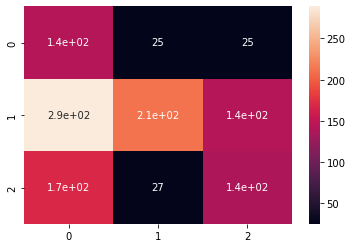

In [17]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)

sns.heatmap(cm, annot=True)
plt.show()

# using TF-IDF

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
tfidf_v = TfidfVectorizer(max_features=5000, ngram_range=(1,3))
X = tfidf_v.fit_transform(corpus).toarray()
y = df['Sentiment']

In [20]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
print(X1_train.shape)
print(X1_test.shape)
print(y1_train.shape)
print(y1_test.shape)

(4381, 5000)
(1461, 5000)
(4381,)
(1461,)


In [21]:
count_df = pd.DataFrame(X1_train, columns=tfidf_v.get_feature_names())
count_df

,aapl,aapl http,aapl http co,ab,ab inbev,ab sto,abb,abl,abp,abp hel,...,yhoo,yhtyma,yhtyma oyj,yhtyma oyj hel,yit,yit corpor,york,zinc,znga,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# model training and model evaluation (TF-IDF)

In [22]:
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

## naive bayes

In [23]:
classifier = GaussianNB()
classifier.fit(X1_train, y1_train)
y1_pred = classifier.predict(X1_test)

In [24]:
acc2 = accuracy_score(y1_test, y1_pred)
print(f"Accuracy of Naive Bayes (Using TF - IDF technique): {acc2}")

Accuracy of Naive Bayes (Using TF - IDF technique): 0.5400410677618069


## multinominalNB

In [25]:
classifier = MultinomialNB()
classifier.fit(X1_train, y1_train)
pred = classifier.predict(X1_test)
score = accuracy_score(y1_test, pred)
score

0.6721423682409309

## CatBoost

Learning rate set to 0.0856
0:	learn: 1.0744115	total: 77.6ms	remaining: 1m 17s
1:	learn: 1.0542612	total: 84.1ms	remaining: 42s
2:	learn: 1.0334723	total: 89.6ms	remaining: 29.8s
3:	learn: 1.0197677	total: 94.8ms	remaining: 23.6s
4:	learn: 1.0055921	total: 100ms	remaining: 20s
5:	learn: 0.9939193	total: 106ms	remaining: 17.5s
6:	learn: 0.9835225	total: 111ms	remaining: 15.7s
7:	learn: 0.9734878	total: 116ms	remaining: 14.4s
8:	learn: 0.9654381	total: 122ms	remaining: 13.4s
9:	learn: 0.9573342	total: 127ms	remaining: 12.6s
10:	learn: 0.9512071	total: 132ms	remaining: 11.9s
11:	learn: 0.9457943	total: 137ms	remaining: 11.3s
12:	learn: 0.9388886	total: 143ms	remaining: 10.8s
13:	learn: 0.9343741	total: 148ms	remaining: 10.4s
14:	learn: 0.9314254	total: 153ms	remaining: 10.1s
15:	learn: 0.9256993	total: 159ms	remaining: 9.76s
16:	learn: 0.9215086	total: 164ms	remaining: 9.51s
17:	learn: 0.9178308	total: 169ms	remaining: 9.24s
18:	learn: 0.9141908	total: 174ms	remaining: 9s
19:	learn: 0.90

195:	learn: 0.7128648	total: 1.17s	remaining: 4.81s
196:	learn: 0.7124275	total: 1.18s	remaining: 4.82s
197:	learn: 0.7118042	total: 1.19s	remaining: 4.82s
198:	learn: 0.7114311	total: 1.2s	remaining: 4.82s
199:	learn: 0.7108529	total: 1.2s	remaining: 4.81s
200:	learn: 0.7104003	total: 1.21s	remaining: 4.81s
201:	learn: 0.7095115	total: 1.22s	remaining: 4.8s
202:	learn: 0.7087765	total: 1.22s	remaining: 4.8s
203:	learn: 0.7083128	total: 1.23s	remaining: 4.79s
204:	learn: 0.7078130	total: 1.24s	remaining: 4.79s
205:	learn: 0.7071570	total: 1.24s	remaining: 4.79s
206:	learn: 0.7067906	total: 1.25s	remaining: 4.78s
207:	learn: 0.7063573	total: 1.25s	remaining: 4.77s
208:	learn: 0.7057095	total: 1.26s	remaining: 4.76s
209:	learn: 0.7052031	total: 1.26s	remaining: 4.75s
210:	learn: 0.7046918	total: 1.27s	remaining: 4.74s
211:	learn: 0.7042456	total: 1.27s	remaining: 4.74s
212:	learn: 0.7036575	total: 1.28s	remaining: 4.73s
213:	learn: 0.7032103	total: 1.28s	remaining: 4.72s
214:	learn: 0.70

383:	learn: 0.6421067	total: 2.47s	remaining: 3.96s
384:	learn: 0.6417690	total: 2.48s	remaining: 3.95s
385:	learn: 0.6411900	total: 2.48s	remaining: 3.95s
386:	learn: 0.6408376	total: 2.49s	remaining: 3.94s
387:	learn: 0.6405662	total: 2.49s	remaining: 3.93s
388:	learn: 0.6403285	total: 2.5s	remaining: 3.92s
389:	learn: 0.6400429	total: 2.5s	remaining: 3.92s
390:	learn: 0.6397946	total: 2.51s	remaining: 3.91s
391:	learn: 0.6395024	total: 2.51s	remaining: 3.9s
392:	learn: 0.6391996	total: 2.52s	remaining: 3.89s
393:	learn: 0.6390028	total: 2.52s	remaining: 3.88s
394:	learn: 0.6386211	total: 2.53s	remaining: 3.88s
395:	learn: 0.6382673	total: 2.54s	remaining: 3.87s
396:	learn: 0.6380907	total: 2.54s	remaining: 3.86s
397:	learn: 0.6378415	total: 2.55s	remaining: 3.85s
398:	learn: 0.6375731	total: 2.55s	remaining: 3.85s
399:	learn: 0.6373641	total: 2.56s	remaining: 3.84s
400:	learn: 0.6371113	total: 2.56s	remaining: 3.83s
401:	learn: 0.6366698	total: 2.57s	remaining: 3.82s
402:	learn: 0.6

555:	learn: 0.6029974	total: 3.45s	remaining: 2.76s
556:	learn: 0.6029321	total: 3.46s	remaining: 2.75s
557:	learn: 0.6027151	total: 3.46s	remaining: 2.75s
558:	learn: 0.6025807	total: 3.47s	remaining: 2.74s
559:	learn: 0.6024558	total: 3.48s	remaining: 2.73s
560:	learn: 0.6022336	total: 3.48s	remaining: 2.73s
561:	learn: 0.6021005	total: 3.49s	remaining: 2.72s
562:	learn: 0.6019743	total: 3.49s	remaining: 2.71s
563:	learn: 0.6017898	total: 3.5s	remaining: 2.71s
564:	learn: 0.6016201	total: 3.51s	remaining: 2.7s
565:	learn: 0.6014655	total: 3.51s	remaining: 2.69s
566:	learn: 0.6013192	total: 3.52s	remaining: 2.69s
567:	learn: 0.6011291	total: 3.52s	remaining: 2.68s
568:	learn: 0.6010078	total: 3.53s	remaining: 2.67s
569:	learn: 0.6008387	total: 3.54s	remaining: 2.67s
570:	learn: 0.6005055	total: 3.54s	remaining: 2.66s
571:	learn: 0.6002891	total: 3.55s	remaining: 2.65s
572:	learn: 0.6000781	total: 3.55s	remaining: 2.65s
573:	learn: 0.5997595	total: 3.56s	remaining: 2.64s
574:	learn: 0.

717:	learn: 0.5761697	total: 4.42s	remaining: 1.73s
718:	learn: 0.5759861	total: 4.42s	remaining: 1.73s
719:	learn: 0.5757485	total: 4.43s	remaining: 1.72s
720:	learn: 0.5756224	total: 4.43s	remaining: 1.72s
721:	learn: 0.5754500	total: 4.44s	remaining: 1.71s
722:	learn: 0.5752620	total: 4.45s	remaining: 1.7s
723:	learn: 0.5751441	total: 4.45s	remaining: 1.7s
724:	learn: 0.5749912	total: 4.46s	remaining: 1.69s
725:	learn: 0.5748828	total: 4.46s	remaining: 1.68s
726:	learn: 0.5747365	total: 4.47s	remaining: 1.68s
727:	learn: 0.5745728	total: 4.47s	remaining: 1.67s
728:	learn: 0.5744096	total: 4.48s	remaining: 1.67s
729:	learn: 0.5742557	total: 4.49s	remaining: 1.66s
730:	learn: 0.5741691	total: 4.49s	remaining: 1.65s
731:	learn: 0.5739900	total: 4.5s	remaining: 1.65s
732:	learn: 0.5737955	total: 4.5s	remaining: 1.64s
733:	learn: 0.5736392	total: 4.51s	remaining: 1.63s
734:	learn: 0.5735502	total: 4.51s	remaining: 1.63s
735:	learn: 0.5733149	total: 4.52s	remaining: 1.62s
736:	learn: 0.57

880:	learn: 0.5544085	total: 5.39s	remaining: 728ms
881:	learn: 0.5543123	total: 5.4s	remaining: 722ms
882:	learn: 0.5542350	total: 5.4s	remaining: 716ms
883:	learn: 0.5540466	total: 5.41s	remaining: 710ms
884:	learn: 0.5539960	total: 5.41s	remaining: 704ms
885:	learn: 0.5538358	total: 5.42s	remaining: 697ms
886:	learn: 0.5537052	total: 5.42s	remaining: 691ms
887:	learn: 0.5536507	total: 5.43s	remaining: 685ms
888:	learn: 0.5535382	total: 5.43s	remaining: 679ms
889:	learn: 0.5534495	total: 5.44s	remaining: 672ms
890:	learn: 0.5533001	total: 5.45s	remaining: 666ms
891:	learn: 0.5531566	total: 5.45s	remaining: 660ms
892:	learn: 0.5530225	total: 5.46s	remaining: 654ms
893:	learn: 0.5529300	total: 5.46s	remaining: 648ms
894:	learn: 0.5528013	total: 5.47s	remaining: 642ms
895:	learn: 0.5527218	total: 5.47s	remaining: 635ms
896:	learn: 0.5525751	total: 5.48s	remaining: 629ms
897:	learn: 0.5524365	total: 5.49s	remaining: 623ms
898:	learn: 0.5523346	total: 5.49s	remaining: 617ms
899:	learn: 0.

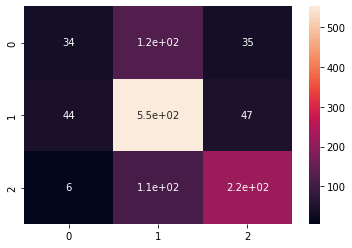

In [26]:
classifier = CatBoostClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)

acc4 = accuracy_score(y_test, y_pred)
print(acc4)

sns.heatmap(cm,annot=True)
plt.show()

## XGBoost

In [ ]:
classifier = XGBClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)

acc3 = accuracy_score(y_test, y_pred)
print(acc3)

sns.heatmap(cm,annot=True)
plt.show()

# references

1. https://www.kaggle.com/sanjoymondal0/financial-sentiment-analysis